## Initial exploration

Helper functions

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import csv
import math
import random

from BSE import market_session

# Initial Setup:
# Import all the libraries we need

import matplotlib.pyplot as plt
import numpy as np
import csv
import math
import random

from BSE import market_session

# The next are helper functions that you will use later, if they don't make 
# much sense now, don't worry too much about it they will become clearer later:

# Use this to plot trades of a single experiment
def plot_trades(trial_id):
    prices_fname = trial_id + '_tape.csv'
    x = np.empty(0)
    y = np.empty(0)
    with open(prices_fname, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            time = float(row[1])
            price = float(row[2])
            x = np.append(x,time)
            y = np.append(y,price)

    plt.plot(x, y, 'x', color='black') 
    
# Use this to run an experiment n times and plot all trades
def n_runs_plot_trades(n, trial_id, start_time, end_time, traders_spec, order_sched):
    x = np.empty(0)
    y = np.empty(0)

    for i in range(n):
        trialId = trial_id + '_' + str(i)
        tdump = open(trialId + '_avg_balance.csv','w')

        market_session(trialId, start_time, end_time, traders_spec, order_sched, tdump, True, False)
        
        tdump.close()

        with open(trialId + '_tape.csv', newline='') as csvfile:
            reader = csv.reader(csvfile)
            for row in reader:
                time = float(row[1])
                price = float(row[2])
                x = np.append(x,time)
                y = np.append(y,price)

    plt.plot(x, y, 'x', color='black');

# !!! Don't use on it's own   
def getorderprice(i, sched, n, mode):
    pmin = min(sched[0][0], sched[0][1])
    pmax = max(sched[0][0], sched[0][1])
    prange = pmax - pmin
    stepsize = prange / (n - 1)
    halfstep = round(stepsize / 2.0)

    if mode == 'fixed':
        orderprice = pmin + int(i * stepsize)
    elif mode == 'jittered':
        orderprice = pmin + int(i * stepsize) + random.randint(-halfstep, halfstep)
    elif mode == 'random':
        if len(sched) > 1:
            # more than one schedule: choose one equiprobably
            s = random.randint(0, len(sched) - 1)
            pmin = min(sched[s][0], sched[s][1])
            pmax = max(sched[s][0], sched[s][1])
        orderprice = random.randint(pmin, pmax)
    return orderprice    

# !!! Don't use on it's own
def make_supply_demand_plot(bids, asks):
    # total volume up to current order
    volS = 0
    volB = 0

    fig, ax = plt.subplots()
    plt.ylabel('Price')
    plt.xlabel('Quantity')
    
    pr = 0
    for b in bids:
        if pr != 0:
            # vertical line
            ax.plot([volB,volB], [pr,b], 'r-')
        # horizontal lines
        line, = ax.plot([volB,volB+1], [b,b], 'r-')
        volB += 1
        pr = b
    if bids:
        line.set_label('Demand')
        
    pr = 0
    for s in asks:
        if pr != 0:
            # vertical line
            ax.plot([volS,volS], [pr,s], 'b-')
        # horizontal lines
        line, = ax.plot([volS,volS+1], [s,s], 'b-')
        volS += 1
        pr = s
    if asks:
        line.set_label('Supply')
        
    if bids or asks:
        plt.legend()
    plt.show()

# Use this to plot supply and demand curves from supply and demand ranges and stepmode
def plot_sup_dem(seller_num, sup_ranges, buyer_num, dem_ranges, stepmode):
    asks = []
    for s in range(seller_num):
        asks.append(getorderprice(s, sup_ranges, seller_num, stepmode))
    asks.sort()
    bids = []
    for b in range(buyer_num):
        bids.append(getorderprice(b, dem_ranges, buyer_num, stepmode))
    bids.sort()
    bids.reverse()
    
    make_supply_demand_plot(bids, asks) 

# plot sorted trades, useful is some situations - won't be used in this worksheet
def in_order_plot(trial_id):
    prices_fname = trial_id + '_tape.csv'
    y = np.empty(0)
    with open(prices_fname, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            price = float(row[2])
            y = np.append(y,price)
    y = np.sort(y)
    x = list(range(len(y)))

    plt.plot(x, y, 'x', color='black')   

# plot offset function
def plot_offset_fn(offset_fn, total_time_seconds):   
    x = list(range(total_time_seconds))
    offsets = []
    for i in range(total_time_seconds):
        offsets.append(offset_fn(i))
    plt.plot(x, offsets, 'x', color='black')  

Simple static market session with PRDE

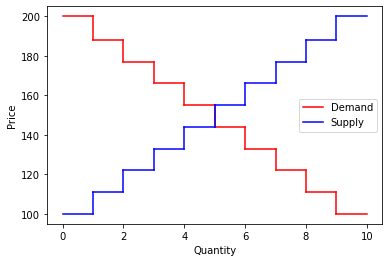

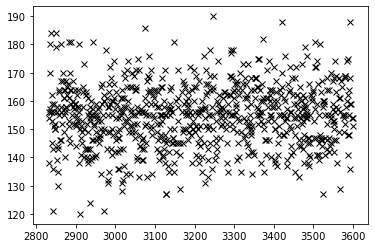

In [4]:
# Solution

# First, configure the trader specifications
sellers_spec = [('PRDE', 30, {'k': 4, 's_min': -1.0, 's_max': +1.0, 'F': 0.8})]
buyers_spec = sellers_spec
traders_spec = {'sellers':sellers_spec, 'buyers':buyers_spec}

# Next, confiure the supply and demand (and plot it)
sup_range = (100, 200)
dem_range = sup_range

plot_sup_dem(10, [sup_range], 10, [dem_range], 'fixed')

# Next, configure order schedules

start_time = 0
end_time = 60 * 60
supply_schedule = [{'from': start_time, 'to': end_time, 'ranges': [sup_range], 'stepmode': 'fixed'}]
demand_schedule = [{'from': start_time, 'to': end_time, 'ranges': [dem_range], 'stepmode': 'fixed'}]

order_interval = 5
order_sched = {'sup': supply_schedule, 'dem': demand_schedule,
               'interval': order_interval, 'timemode': 'periodic'}

trial_id = 'test_1'
tdump = open('test_1_avg_balance.csv','w')
dump_all = True
verbose = False

# Now, run the market session
market_session(trial_id, start_time, end_time, traders_spec, order_sched, tdump, dump_all, verbose)

tdump.close()

# Finally, plot the trades that executed during the market session
plot_trades('test_1')

In [58]:
def run_session(k, F, trial_id_str, csv_str):
    # First, configure the trader specifications
    #I have no clue if F is actually being set
    sellers_spec = [('PRDE', 20, {'k': k, 's_min': -1.0, 's_max': +1.0, 'diffevol["F"]':F})]
    buyers_spec = sellers_spec
    traders_spec = {'sellers':sellers_spec, 'buyers':buyers_spec}

    # Next, confiure the supply and demand (and plot it)
    sup_range = (100, 200)
    dem_range = sup_range

    plot_sup_dem(20, [sup_range], 20, [dem_range], 'fixed')

    # Next, configure order schedules

    start_time = 0
    end_time = 60 * 3
    supply_schedule = [{'from': start_time, 'to': end_time, 'ranges': [sup_range], 'stepmode': 'fixed'}]
    demand_schedule = [{'from': start_time, 'to': end_time, 'ranges': [dem_range], 'stepmode': 'fixed'}]

    order_interval = 10
    order_sched = {'sup': supply_schedule, 'dem': demand_schedule,
               'interval': order_interval, 'timemode': 'drip-jitter'}

    trial_id = trial_id_str
    tdump = open(csv_str,'w')
    dump_all = True
    verbose = False

    # Now, run the market session
    market_session(trial_id, start_time, end_time, traders_spec, order_sched, tdump, dump_all, verbose)

    tdump.close()

    # Finally, plot the trades that executed during the market session
    plot_trades(trial_id_str)

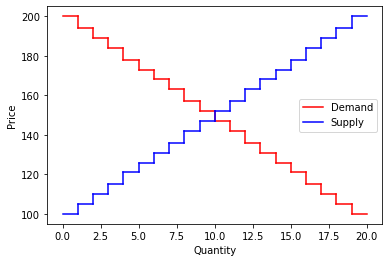

B00: PRDE active_strat=[0]:
[0]: s=+0.593438, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.241940, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.412272, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.055129, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=+0.047710, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.984825, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.043301, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.688577, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=+0.060573, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.773744, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.847164, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.619817, start=0.000000, $=0.000000, pps=0.000000


B03: PRDE active_strat=[0]:
[0]: s=-0.654256, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.249334, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.334160, start=0.000000, $=0.000000, pps=0.0000

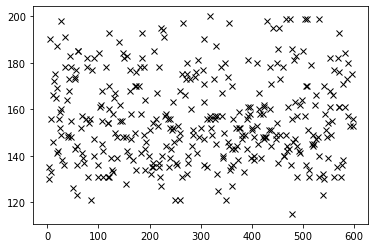

In [51]:
run_session(4, 2.0, 'test_2', 'test_2_avg_balance.csv')
#they do appear to be making profits etc, but for some reason the PRDE output seems to be wrong/concerning? (start time=0, profit=0, profit per second=0)

In [33]:
import scipy as sp
from scipy import stats
import seaborn as sns 
import matplotlib.pyplot as plt 
import statsmodels.api as sm
import pandas as pd

In [57]:
#there's some randomness, figure out where

df = pd.read_csv('test_2_avg_balance.csv')
print(df.head())
profit = df.iloc[:,5].mean()
print(profit)
profits = pd.DataFrame(data=[profit])
profits.to_csv('profit.csv')

   test_2   000002   114   135   PRDE   63   40   1.575000   
0  test_2        2    95   164   PRDE  100   40      2.500   
1  test_2        5   183   200   PRDE  148   40      3.700   
2  test_2        7   133   169   PRDE  237   40      5.925   
3  test_2        8   132   169   PRDE  315   40      7.875   
4  test_2       10   101   166   PRDE  362   40      9.050   
10399.185595567867


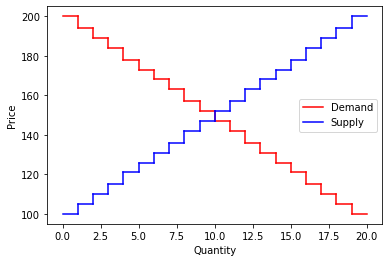

B00: PRDE active_strat=[0]:
[0]: s=+0.923710, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.392824, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.602502, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.150439, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=+0.178339, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.156306, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.568384, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.103146, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=+0.215934, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.269899, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.700745, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.264331, start=0.000000, $=0.000000, pps=0.000000


B03: PRDE active_strat=[0]:
[0]: s=-0.268152, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.000842, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.585830, start=0.000000, $=0.000000, pps=0.0000

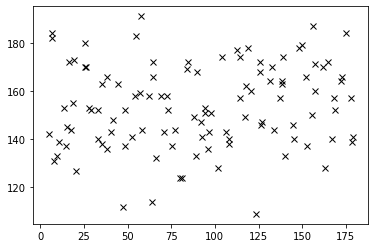

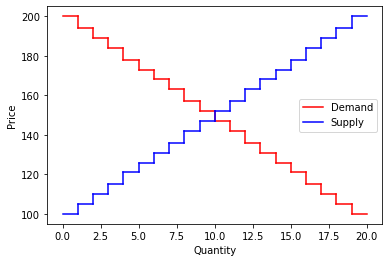

B00: PRDE active_strat=[0]:
[0]: s=-0.134784, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.345788, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.241976, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.826365, start=0.000000, $=0.000000, pps=0.000000
[4]: s=+0.293766, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=+0.222546, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.970303, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.551256, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.167391, start=0.000000, $=0.000000, pps=0.000000
[4]: s=-0.999611, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=-0.270990, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.330024, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.561588, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.810084, start=0.000000, $=0.000000, pps=0.000000
[4]: s=+0.313934, start=0.000000, $=0.000000, pps=0.000000


B03: PRDE active_strat=[0

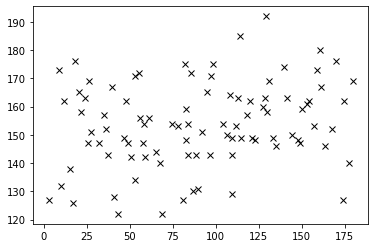

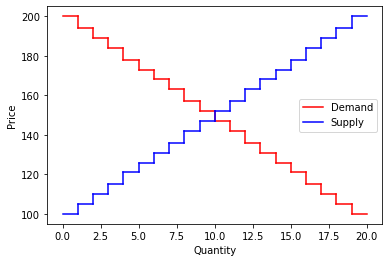

B00: PRDE active_strat=[0]:
[0]: s=-0.736380, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.410852, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.141903, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.205858, start=0.000000, $=0.000000, pps=0.000000
[4]: s=+0.106530, start=0.000000, $=0.000000, pps=0.000000
[5]: s=+0.510008, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=-0.851212, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.285601, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.617667, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.544760, start=0.000000, $=0.000000, pps=0.000000
[4]: s=-0.158956, start=0.000000, $=0.000000, pps=0.000000
[5]: s=-0.074720, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=-0.113030, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.476489, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.623279, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.992601, start=0.0

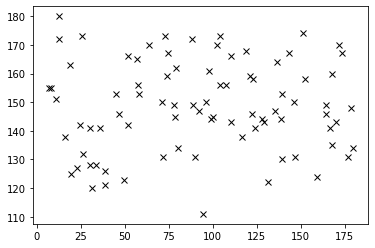

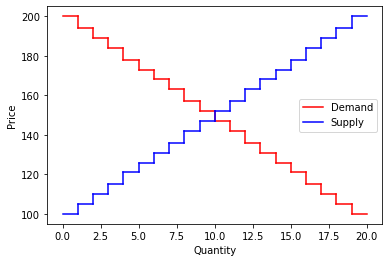

B00: PRDE active_strat=[0]:
[0]: s=+0.313028, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.205080, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.575561, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.877569, start=0.000000, $=0.000000, pps=0.000000
[4]: s=+0.030363, start=0.000000, $=0.000000, pps=0.000000
[5]: s=+0.322354, start=0.000000, $=0.000000, pps=0.000000
[6]: s=+0.876169, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=-0.052557, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.761395, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.314095, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.948129, start=0.000000, $=0.000000, pps=0.000000
[4]: s=+0.719235, start=0.000000, $=0.000000, pps=0.000000
[5]: s=-0.410068, start=0.000000, $=0.000000, pps=0.000000
[6]: s=-0.278947, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=+0.229751, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.567275, start=0.0

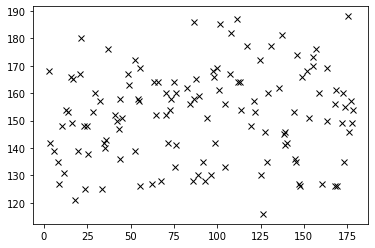

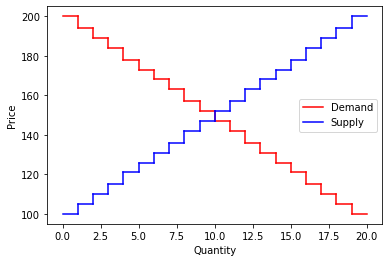

B00: PRDE active_strat=[0]:
[0]: s=+0.795580, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.543143, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.545149, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.073155, start=0.000000, $=0.000000, pps=0.000000
[4]: s=-0.165567, start=0.000000, $=0.000000, pps=0.000000
[5]: s=+0.719441, start=0.000000, $=0.000000, pps=0.000000
[6]: s=+0.253388, start=0.000000, $=0.000000, pps=0.000000
[7]: s=-0.439758, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=+0.414513, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.647073, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.501628, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.707374, start=0.000000, $=0.000000, pps=0.000000
[4]: s=-0.210694, start=0.000000, $=0.000000, pps=0.000000
[5]: s=-0.837653, start=0.000000, $=0.000000, pps=0.000000
[6]: s=-0.522119, start=0.000000, $=0.000000, pps=0.000000
[7]: s=-0.157853, start=0.000000, $=0.000000, pps=0.00000

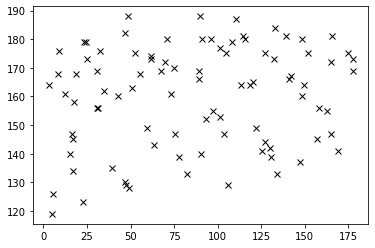

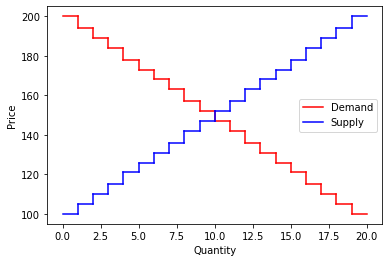

B00: PRDE active_strat=[0]:
[0]: s=-0.949728, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.289948, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.073431, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.640080, start=0.000000, $=0.000000, pps=0.000000
[4]: s=-0.807814, start=0.000000, $=0.000000, pps=0.000000
[5]: s=-0.695053, start=0.000000, $=0.000000, pps=0.000000
[6]: s=+0.138966, start=0.000000, $=0.000000, pps=0.000000
[7]: s=+0.462759, start=0.000000, $=0.000000, pps=0.000000
[8]: s=+0.667827, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=-0.598496, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.733870, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.202566, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.506401, start=0.000000, $=0.000000, pps=0.000000
[4]: s=-0.076403, start=0.000000, $=0.000000, pps=0.000000
[5]: s=+0.346002, start=0.000000, $=0.000000, pps=0.000000
[6]: s=-0.862548, start=0.000000, $=0.000000, pps=0.00000

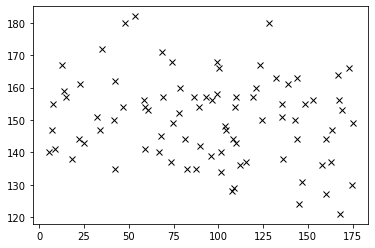

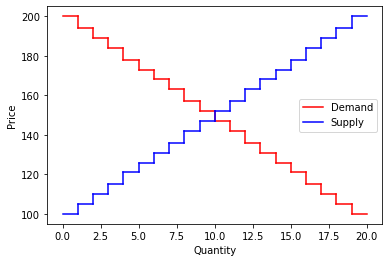

B00: PRDE active_strat=[0]:
[0]: s=-0.501940, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.170338, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.617376, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.043671, start=0.000000, $=0.000000, pps=0.000000
[4]: s=+0.855864, start=0.000000, $=0.000000, pps=0.000000
[5]: s=+0.708423, start=0.000000, $=0.000000, pps=0.000000
[6]: s=-0.484090, start=0.000000, $=0.000000, pps=0.000000
[7]: s=-0.059649, start=0.000000, $=0.000000, pps=0.000000
[8]: s=-0.637760, start=0.000000, $=0.000000, pps=0.000000
[9]: s=-0.670045, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=+0.581960, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.549967, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.593284, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.835627, start=0.000000, $=0.000000, pps=0.000000
[4]: s=-0.531318, start=0.000000, $=0.000000, pps=0.000000
[5]: s=-0.015551, start=0.000000, $=0.000000, pps=0.00000

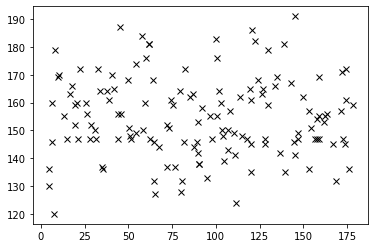

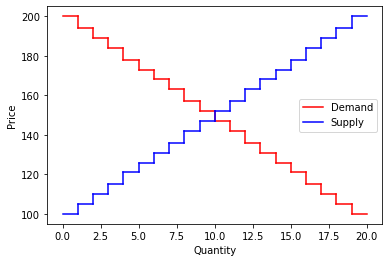

B00: PRDE active_strat=[0]:
[0]: s=+0.273020, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.516369, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.782446, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.366745, start=0.000000, $=0.000000, pps=0.000000
[4]: s=+0.352257, start=0.000000, $=0.000000, pps=0.000000
[5]: s=+0.995482, start=0.000000, $=0.000000, pps=0.000000
[6]: s=+0.778531, start=0.000000, $=0.000000, pps=0.000000
[7]: s=-0.505444, start=0.000000, $=0.000000, pps=0.000000
[8]: s=+0.356888, start=0.000000, $=0.000000, pps=0.000000
[9]: s=-0.623807, start=0.000000, $=0.000000, pps=0.000000
[10]: s=+0.687267, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=-0.311584, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.130194, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.490612, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.029448, start=0.000000, $=0.000000, pps=0.000000
[4]: s=+0.409947, start=0.000000, $=0.000000, pps=0.0000

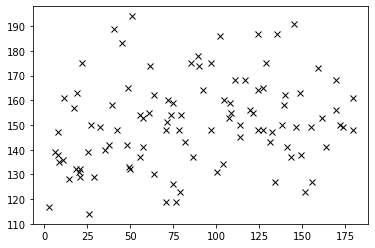

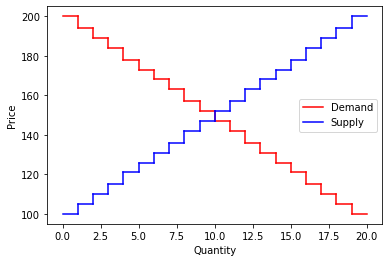

B00: PRDE active_strat=[0]:
[0]: s=+0.216528, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.760081, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.640829, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.343494, start=0.000000, $=0.000000, pps=0.000000
[4]: s=+0.357088, start=0.000000, $=0.000000, pps=0.000000
[5]: s=-0.944801, start=0.000000, $=0.000000, pps=0.000000
[6]: s=+0.150701, start=0.000000, $=0.000000, pps=0.000000
[7]: s=-0.782767, start=0.000000, $=0.000000, pps=0.000000
[8]: s=+0.540909, start=0.000000, $=0.000000, pps=0.000000
[9]: s=-0.494368, start=0.000000, $=0.000000, pps=0.000000
[10]: s=+0.259660, start=0.000000, $=0.000000, pps=0.000000
[11]: s=+0.485673, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=+0.801799, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.173362, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.002342, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.239433, start=0.000000, $=0.000000, pps=0.000

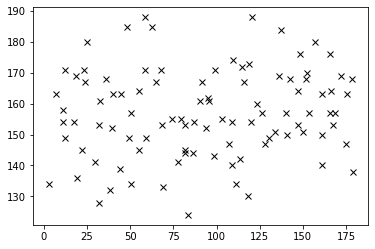

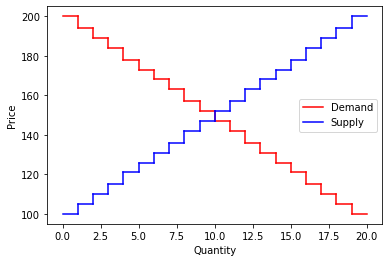

B00: PRDE active_strat=[0]:
[0]: s=+0.293131, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.056408, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.311990, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.317173, start=0.000000, $=0.000000, pps=0.000000
[4]: s=-0.675576, start=0.000000, $=0.000000, pps=0.000000
[5]: s=-0.129714, start=0.000000, $=0.000000, pps=0.000000
[6]: s=+0.486259, start=0.000000, $=0.000000, pps=0.000000
[7]: s=-0.827360, start=0.000000, $=0.000000, pps=0.000000
[8]: s=-0.861753, start=0.000000, $=0.000000, pps=0.000000
[9]: s=-0.549035, start=0.000000, $=0.000000, pps=0.000000
[10]: s=+0.749968, start=0.000000, $=0.000000, pps=0.000000
[11]: s=+0.511144, start=0.000000, $=0.000000, pps=0.000000
[12]: s=-0.988601, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=-0.692088, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.822919, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.300423, start=0.000000, $=0.000000, pps=0.00

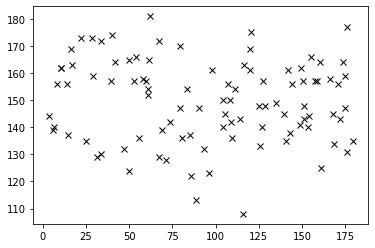

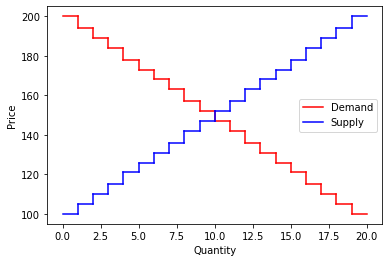

B00: PRDE active_strat=[0]:
[0]: s=+0.728225, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.209577, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.462422, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.835941, start=0.000000, $=0.000000, pps=0.000000
[4]: s=-0.985475, start=0.000000, $=0.000000, pps=0.000000
[5]: s=+0.140326, start=0.000000, $=0.000000, pps=0.000000
[6]: s=+0.190361, start=0.000000, $=0.000000, pps=0.000000
[7]: s=-0.825606, start=0.000000, $=0.000000, pps=0.000000
[8]: s=-0.171895, start=0.000000, $=0.000000, pps=0.000000
[9]: s=-0.536073, start=0.000000, $=0.000000, pps=0.000000
[10]: s=-0.370561, start=0.000000, $=0.000000, pps=0.000000
[11]: s=-0.593110, start=0.000000, $=0.000000, pps=0.000000
[12]: s=-0.221972, start=0.000000, $=0.000000, pps=0.000000
[13]: s=+0.409465, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=-0.963635, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.716746, start=0.000000, $=0.000000, pps=0.0

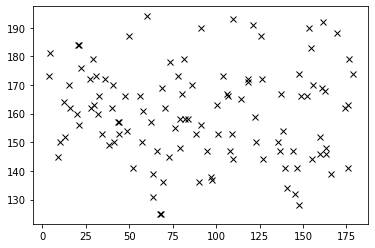

In [59]:
i = 4
profits = []
while i < 15:
    run_session(i, 0.8, 'test_3', 'test_3_avg_balance.csv')
    df = pd.read_csv('test_3_avg_balance.csv')
    profits.append(df.iloc[:,5].mean())
    i = i+1

In [63]:
print(profits)
profits_df = pd.DataFrame([[i] for i in profits])
profits_df.to_csv('profit.csv')

[3144.532110091743, 2690.945652173913, 2478.3493975903616, 3198.3671875, 2479.588888888889, 2658.813953488372, 3416.0785714285716, 2536.421568627451, 2275.020618556701, 2820.875, 2954.6548672566373]
